# **KBO 외국인 투수 스카우팅 최적화**

- 목표
    - 스카우팅 시점에서 외국인 투수의 성적을 예측
    - 평가척도: 전달력, 논리성, 실용성, 간결성

- 접근 방식
    - '첫 시즌'부터 좋은 성적을 보여줄 투수를 확보
    - 엘리트 투수 그룹: KBO 영입 후 첫 번째 시즌에서 좋은 성적을 보여준 외국인 투수 그룹을 선정
        - 2011 ~ 2018 활약한 외국인 투수 중
        - 첫 번째 시즌의 평균 자책점(ERA)이 상위 50%에 속하면서, 상대 타자 수 또한 상위 50%에 속하는 그룹
    - KBO 영입 전 MLB에서의 제구력 평가
        - 제구력: 스트라이크 판정된 투구 비중이 10% 이상인 구종의 개수로 정의
- 데이터
    - 2011~2018 KBO에서 활약한 외국인 투수
        - kbo_yearly_foreigners_2011_2018.csv: 역대 KBO 정규시즌 성적
        - fangraphs_foreigners_2011_2018.csv: KBO 입성 전, MLB에서의 역대 정규시즌 성적
        - baseball_savant_foreigners_2011_2018.csv: KBO 입성 전, MLB에서의 스탯캐스터 데이터
    - 2019년 신규 KBO 외국인 투수
        - fangraphs_foreigners_2019.csv: MLB에서의 역대 정규시즌성적
        - baseball_savant_foreigners_2019.csv: MLB에서의 스탯캐스터 데이터

## **Import packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import os
import warnings
warnings.filterwarnings("ignore")

os.chdir("/content/drive/MyDrive/[책] 데이콘 경진대회 1등 솔루션/KBO 외국인 투수 스카우팅 최적화")

## **탐색적 데이터 분석(EDA)**

### **_KBO/팬그래프 데이터**

- KBO와 MLB에 대해 핵심 지표인 ERA, TBF를 확인
- TBF의 경우 KBO에서는 평균 이상의 값이 많지만, MLB에서는 평균 이하의 값이 많은
    - 영입한 외국인 투수의 경우 MLB에서는 불펜이지만 KBO에서는 주로 선발 투구 역할을 하기 때문으로 예상.
- MLB에서의 ERA가 낮을수록 KBO에서도 낮을 것으로 예상하고 확인
    - 상관관계 결과 0.108

In [2]:
atkbo_11_18_kboRegSsn = pd.read_csv("DAT/kbo_yearly_foreigners_2011_2018.csv")
atkbo_11_18_MlbTot = pd.read_csv("DAT/fangraphs_foreigners_2011_2018.csv")
atkbo_19_MlbTot = pd.read_csv("DAT/fangraphs_foreigners_2019.csv")

print(atkbo_11_18_kboRegSsn.shape)
print(atkbo_11_18_MlbTot.shape)
print(atkbo_19_MlbTot.shape)

(105, 11)
(205, 19)
(41, 19)


In [3]:
display(atkbo_11_18_kboRegSsn.head(3))
display(atkbo_11_18_MlbTot.head(3))
display(atkbo_19_MlbTot.head(3))

,pitcher_name,year,team,ERA,TBF,H,HR,BB,HBP,SO,year_born
0,니퍼트,2011,두산,2.55,763,150,8,64,10,150,NaN
1,니퍼트,2012,두산,3.20,785,156,15,68,8,126,NaN
2,니퍼트,2013,두산,3.58,482,108,7,34,4,104,NaN


,pitcher_name,year,ERA,WAR,TBF,H,HR,BB,HBP,SO,WHIP,BABIP,FIP,LD%,GB%,FB%,IFFB%,SwStr%,Swing%
0,오간도,2011.0,3.51,3.3,693.0,149.0,16.0,43.0,7.0,126.0,1.14,0.265,3.65,0.237,0.364,0.674,0.147,0.090,0.475
1,험버,2011.0,3.75,3.2,676.0,151.0,14.0,41.0,6.0,116.0,1.18,0.275,3.58,0.168,0.471,0.458,0.094,0.092,0.463
2,루카스,2012.0,3.76,2.8,827.0,185.0,13.0,78.0,1.0,140.0,1.36,0.289,3.75,0.203,0.572,0.707,0.082,0.062,0.424


,pitcher_name,year,ERA,WAR,TBF,H,HR,BB,HBP,SO,WHIP,BABIP,FIP,LD%,GB%,FB%,IFFB%,SwStr%,Swing%
0,버틀러,2017.0,3.95,0.6,237.0,50.0,4.0,28.0,2.0,30.0,1.43,0.266,4.66,0.224,0.443,0.661,0.138,0.072,0.465
1,터너,2014.0,6.13,0.5,501.0,148.0,12.0,33.0,1.0,71.0,1.60,0.354,4.16,0.208,0.491,0.636,0.052,0.080,0.461
2,터너,2013.0,3.74,0.3,514.0,116.0,11.0,54.0,4.0,77.0,1.44,0.285,4.43,0.195,0.457,0.675,0.047,0.083,0.454


              ERA         TBF
count  105.000000  105.000000
mean     4.714286  558.980952
std      1.733072  224.436816
min      2.380000   40.000000
25%      3.740000  349.000000
50%      4.420000  622.000000
75%      5.230000  758.000000
max     15.750000  870.000000


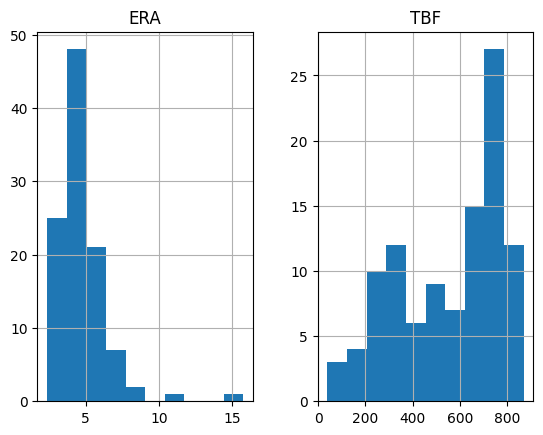

In [4]:
### KBO 정규시즌
# ERA: 평균 자책점 / TBF: 상대한 타자 수
atkbo_11_18_kboRegSsn[["ERA", "TBF"]].hist()
print(atkbo_11_18_kboRegSsn[["ERA", "TBF"]].describe())

              ERA         TBF
count  205.000000  205.000000
mean     5.750585  193.160976
std      3.404285  186.000312
min      0.000000    4.000000
25%      4.050000   57.000000
50%      5.200000  126.000000
75%      6.750000  263.000000
max     27.000000  827.000000


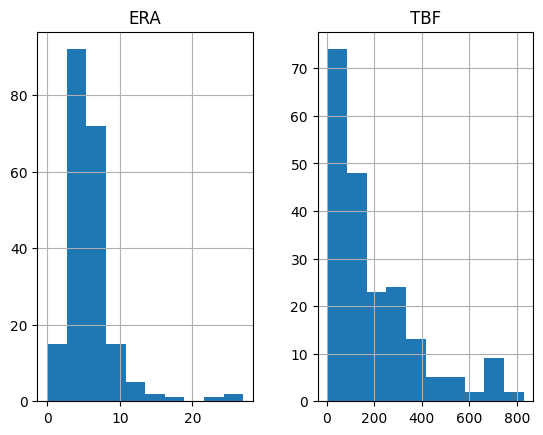

In [5]:
### MLB 정규시즌
# ERA: 평균 자책점 / TBF: 상대한 타자 수
atkbo_11_18_MlbTot[["ERA", "TBF"]].hist()
print(atkbo_11_18_MlbTot[["ERA", "TBF"]].describe())

In [6]:
### 투수별 MLB와 KBO에서의 ERA 평균 확인
m_mean = (atkbo_11_18_MlbTot.groupby("pitcher_name")["ERA"].mean()
                                                           .reset_index()
                                                           .rename(columns = {"ERA" : "MLB_mean"}))

k_mean = (atkbo_11_18_kboRegSsn.groupby("pitcher_name")["ERA"].mean()
                                                           .reset_index()
                                                           .rename(columns = {"ERA" : "KBO_mean"}))

df = pd.merge(m_mean, k_mean, how = "inner", on = "pitcher_name")
df.head()

,pitcher_name,MLB_mean,KBO_mean
0,니퍼트,4.290000,3.6875
1,다이아몬드,10.262500,4.4200
2,듀브론트,5.106667,4.9200
3,레나도,7.306667,6.8000
4,레온,6.050000,11.2500


          MLB_mean  KBO_mean
MLB_mean  1.000000  0.107744
KBO_mean  0.107744  1.000000


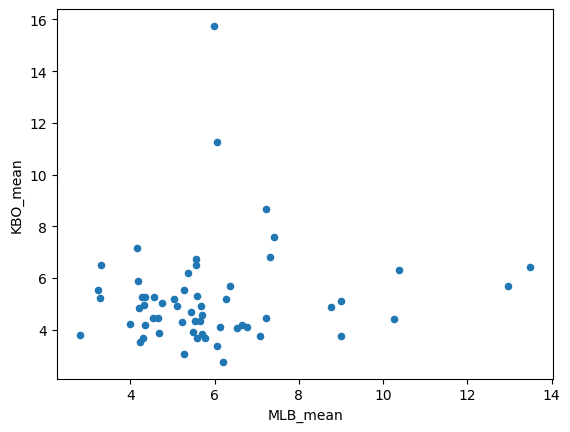

In [7]:
df.plot(kind = "scatter", x = "MLB_mean", y = "KBO_mean")
print(df.corr())

### **_스탯캐스터 데이터**

- 주요 변수인: events, description, pitch_name을 확인
    - events: 해당 타석의 결과
    - description: 해당 공의 결과
    - pitch_name: 구종

In [8]:
atkbo_11_18_StatCast = pd.read_csv("./DAT/baseball_savant_foreigners_2011_2018.csv")
atkbo_19_StatCast = pd.read_csv("./DAT/baseball_savant_foreigners_2019.csv")

print(atkbo_11_18_StatCast.shape)
print(atkbo_19_StatCast.shape)

(135753, 24)
(21903, 24)


In [9]:
display(atkbo_11_18_StatCast.head(3))
display(atkbo_19_StatCast.head(3))

,game_date,release_speed,batter,pitcher,events,description,zone,stand,p_throws,bb_type,...,plate_x,plate_z,ax,ay,az,launch_speed,launch_angle,release_spin_rate,pitch_name,pitcher_name
0,2010-10-09,93.0,425834.0,430962,field_out,hit_into_play,4.0,R,R,popup,...,-0.626,2.771,-6.404,26.077,-9.694,NaN,NaN,NaN,4-Seam Fastball,니퍼트
1,2010-10-09,95.2,150289.0,430962,home_run,hit_into_play_score,5.0,L,R,fly_ball,...,-0.112,2.401,-10.168,28.786,-8.895,NaN,NaN,NaN,4-Seam Fastball,니퍼트
2,2010-10-09,94.3,150289.0,430962,NaN,foul,2.0,L,R,NaN,...,0.272,3.052,-5.605,26.657,-7.794,NaN,NaN,NaN,4-Seam Fastball,니퍼트


,game_date,release_speed,batter,pitcher,events,description,zone,stand,p_throws,bb_type,...,plate_x,plate_z,ax,ay,az,launch_speed,launch_angle,release_spin_rate,pitch_name,pitcher_name
0,2018-05-03,85.4,519058,518445,sac_fly,hit_into_play_score,13.0,L,L,fly_ball,...,-0.9200,2.0320,-6.1015,22.5146,-29.0091,90.4,26.0,2305.0,Cutter,채드벨
1,2018-05-03,91.7,519058,518445,NaN,foul,12.0,L,L,NaN,...,0.4845,3.5506,6.7067,29.5849,-15.5999,72.7,14.0,2265.0,4-Seam Fastball,채드벨
2,2018-05-03,86.1,519058,518445,NaN,foul,13.0,L,L,NaN,...,-1.4736,1.6516,-5.7169,25.0563,-27.4184,NaN,NaN,2379.0,Cutter,채드벨


In [10]:
# events: 해당 타석의 결과 , description: 해당 공의 결과, pitch_name: 구종
atkbo_11_18_StatCast[["events", "description", "pitch_name"]].head()

,events,description,pitch_name
0,field_out,hit_into_play,4-Seam Fastball
1,home_run,hit_into_play_score,4-Seam Fastball
2,NaN,foul,4-Seam Fastball
3,NaN,blocked_ball,4-Seam Fastball
4,NaN,ball,4-Seam Fastball


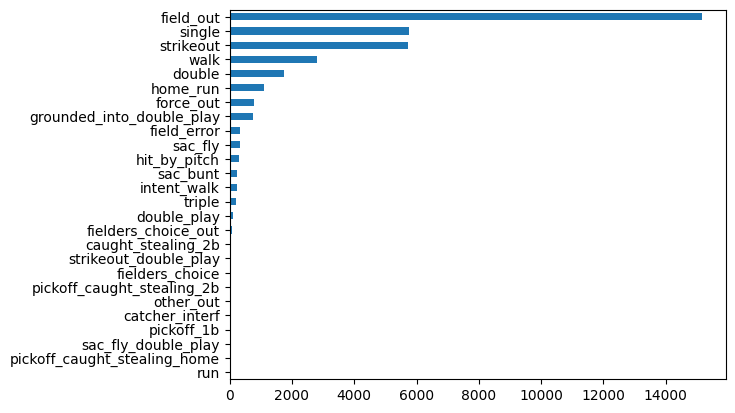

In [11]:
### events의 데이터 분포 확인
(atkbo_11_18_StatCast["events"].value_counts()
                               .sort_values(ascending = True)
                               .plot(kind = "barh"));

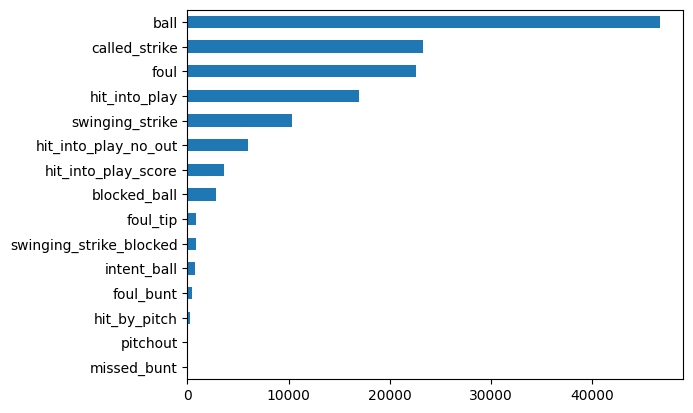

In [12]:
### description의 데이터 분포 확인
(atkbo_11_18_StatCast["description"].value_counts()
                                    .sort_values(ascending = True)
                                    .plot(kind = "barh"));

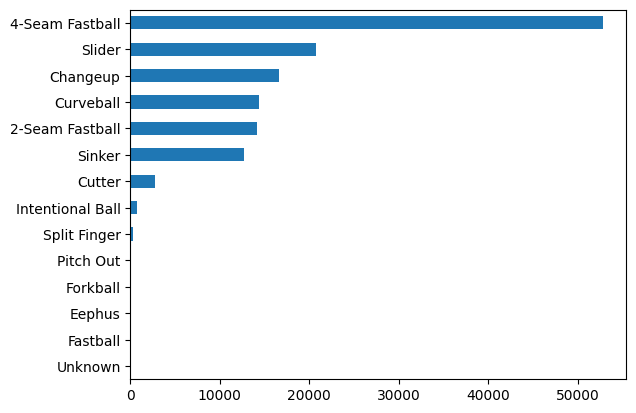

In [13]:
### pitch_name 데이터 분포 확인
(atkbo_11_18_StatCast["pitch_name"].value_counts()
                                   .sort_values(ascending = True)
                                   .plot(kind = "barh"));

## **데이터 전처리**

- 가설 수립: KBO에서 우수한 활약을 보인 투수들은 MLB에서 제구력이 뛰어날 것이다.

- 가설 판별
    1. 가설 확인 대상이 되는 투수는?
    2. KBO에서의 우수한 활약을 측정하는 방법은?
    3. MLB에서의 제구력 측정 방법은?

### **_가설 판별: 대상 투수 집단 선정**

In [14]:
### KBO, MLB, StatCast 모두에 존재하는 투수 추출
print(atkbo_11_18_kboRegSsn["pitcher_name"].nunique())
print(atkbo_11_18_MlbTot["pitcher_name"].nunique())
print(atkbo_11_18_StatCast["pitcher_name"].nunique())

target = (set(atkbo_11_18_kboRegSsn["pitcher_name"]) &
          set(atkbo_11_18_MlbTot["pitcher_name"]) &
          set(atkbo_11_18_StatCast["pitcher_name"]))
target = sorted(list(target))

print(type(target))
print(len(target))

62
60
60
<class 'list'>
57


In [15]:
### 첫 시즌의 ERA가 목표이니 투수별 KBO 첫 시즌 데이터만 추출
_idx = (atkbo_11_18_kboRegSsn.query("pitcher_name in @target")      # pitcher_name이 target에 있는 경우만 추출
                             .groupby("pitcher_name")["year"]
                             .idxmin()                              # 투수별 year 중 가장 작은값(= 첫 시즌 연도)을 갖는 행 추출
                             .values)
print(_idx[:5])

firstYearInKBO_11_18 = atkbo_11_18_kboRegSsn.loc[_idx, :]
firstYearInKBO_11_18.head()

[ 0  8  9 10 11]


,pitcher_name,year,team,ERA,TBF,H,HR,BB,HBP,SO,year_born
0,니퍼트,2011,두산,2.55,763,150,8,64,10,150,NaN
8,다이아몬드,2017,SK,4.42,581,163,11,35,9,59,NaN
9,듀브론트,2018,롯데,4.92,629,162,13,62,8,109,NaN
10,레나도,2017,삼성,6.80,243,70,11,27,6,28,NaN
11,레온,2016,삼성,11.25,40,16,2,1,1,7,NaN


### **_가설 판별: 유효한 데이터 선정하기**

- ERA가 낮더라도 TBF가 낮다면 신뢰할 수 없음
- TBF가 특정 횟수 이상인 투수만 사용
    - 특정 횟수: 분산이 크기 때문에 중앙값(median)을 활용
- ERA 역시 특정 수치보다 작은 투수만 사용
    - 특정 횟수: 분산이 크기 때문에 중앙값(median)을 활용

In [16]:
TBF_median = firstYearInKBO_11_18["TBF"].median()
ERA_median = firstYearInKBO_11_18["ERA"].median()

Elite_11_18 = firstYearInKBO_11_18.query("TBF >= @TBF_median & ERA <= @ ERA_median")
print(Elite_11_18.shape)
Elite_11_18.head()

(18, 11)


,pitcher_name,year,team,ERA,TBF,H,HR,BB,HBP,SO,year_born
0,니퍼트,2011,두산,2.55,763,150,8,64,10,150,NaN
8,다이아몬드,2017,SK,4.42,581,163,11,35,9,59,NaN
12,레이예스,2013,SK,4.84,751,157,15,91,7,135,NaN
14,레일리,2015,롯데,3.91,768,182,20,57,15,134,1988년 06월 29일
25,린드블럼,2015,롯데,3.56,861,196,28,52,12,180,1987년 06월 15일


## **모델 구축과 검증**

- 투수 개인의 능력이 뛰어날 수록 좋은 성적을 낼 것이라 예상.

- 따라서, 해당 능력을 객관적으로 평가하는 지표가 필요.

- MLB 데이터를 통해 투수의 능력을 평가하는 제구력 지표와 아웃 확률을 산출하는 모델을 생성

- 해당 지표를 통해 투수들의 순위를 매긴 후 순위가 가장 높은 투수를 영입하는 프로세스를 구축

### **_선형 회귀 분석**

- 소속팀의 능력, 리그 수준, 경기장 요인에 영향을 받지 않는 제구력으로 투수의 능력을 평가

- 존 외곽에서의 스트라이크 판정이 많은 선수일 수록 좋은 제구력을 갖고 있다고 판단

- 외곽에 분포한 called_strike된 투구 중 구종 비율이 10%가 넘는 것을 유효한 구종이라고 정의 후 해당 구조의 개수로 투수의 제구력을 평가

#### **공과 홈플레이트 시각화**

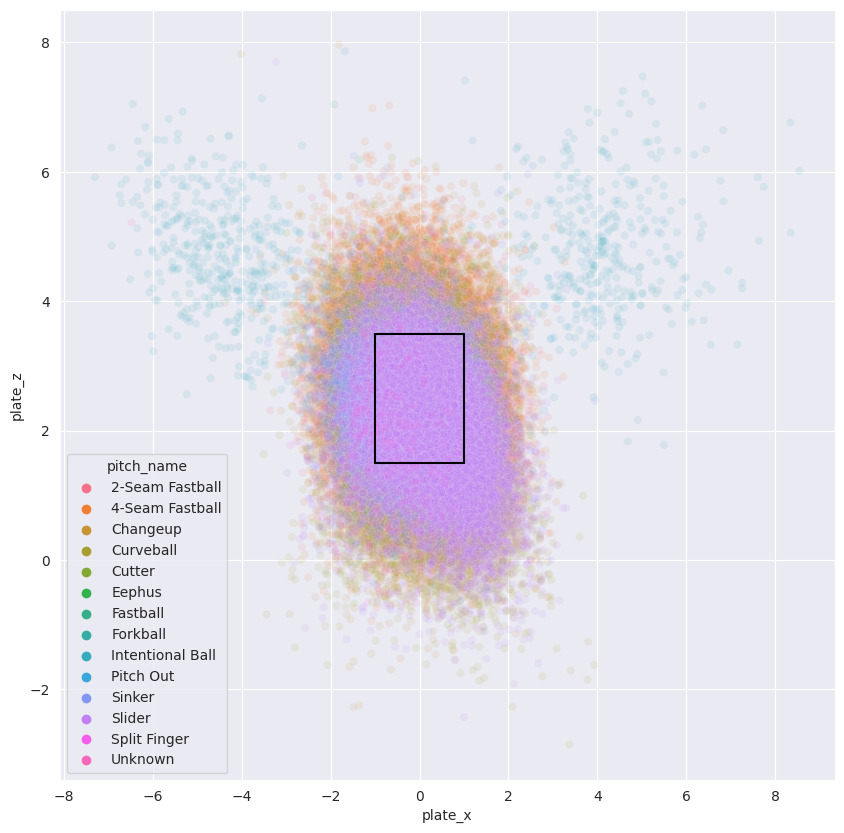

In [17]:
### 공이 홈플레이트를 지날 때의 위치를 시각화
plt.figure(figsize = (10, 10))
sns.set_style("darkgrid")

# 공의 위치
sns.scatterplot(data = atkbo_11_18_StatCast.sort_values("pitch_name"),
                x = "plate_x",
                y = "plate_z",
                hue = "pitch_name",
                alpha = .1)

# 스트라이크 존
plt.plot([-1, -1], [1.5, 3.5], "black")
plt.plot([1, 1], [1.5, 3.5], "black")
plt.plot([-1, 1], [1.5, 1.5], "black")
plt.plot([-1, 1], [3.5, 3.5], "black");

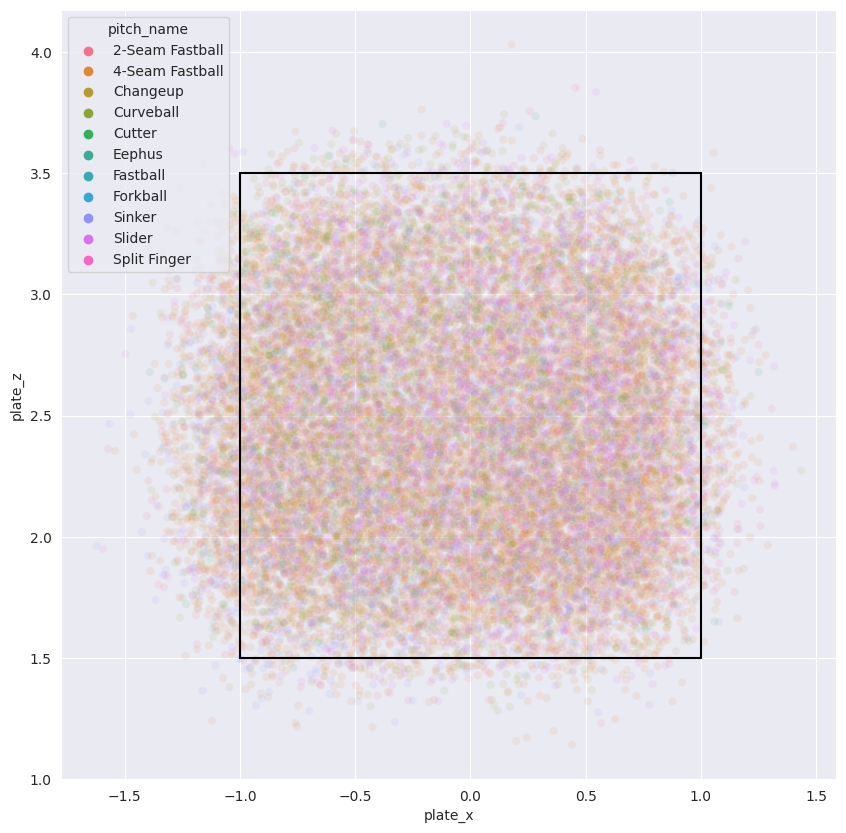

In [18]:
### "스트라이크 판정"을 받은 공만 시각화
plt.figure(figsize = (10, 10))
sns.set_style("darkgrid")

# 공의 위치
sns.scatterplot(data = (atkbo_11_18_StatCast.sort_values("pitch_name").
                                             query('description == "called_strike"')),
                x = "plate_x",
                y = "plate_z",
                hue = "pitch_name",
                alpha = .1)

# 스트라이크 존
plt.plot([-1, -1], [1.5, 3.5], "black")
plt.plot([1, 1], [1.5, 3.5], "black")
plt.plot([-1, 1], [1.5, 1.5], "black")
plt.plot([-1, 1], [3.5, 3.5], "black");

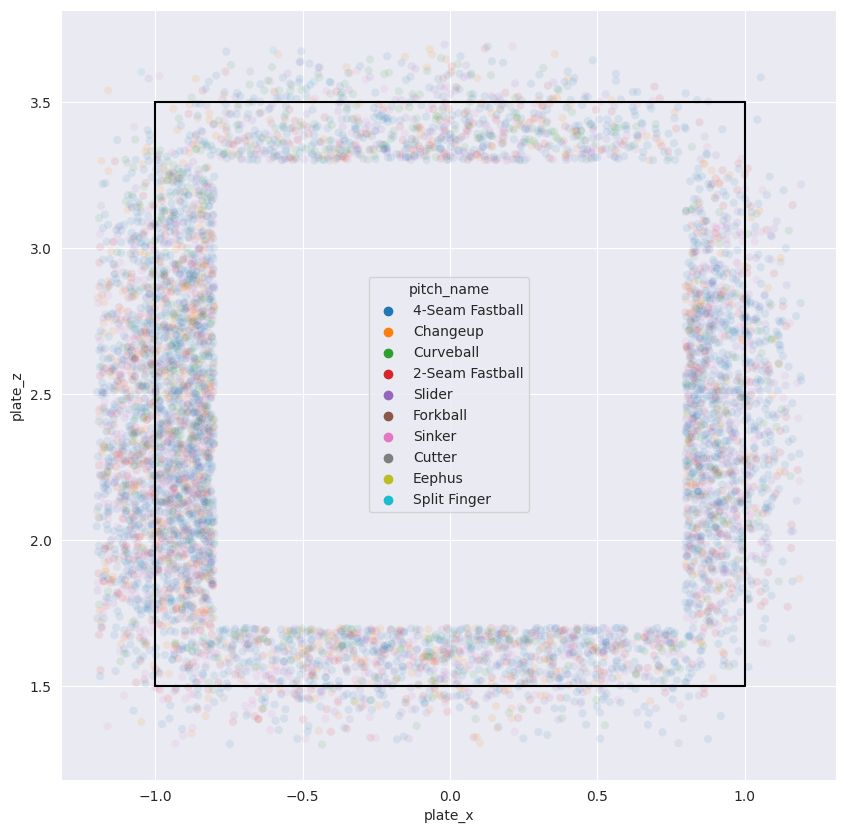

In [19]:
### 존 외곽(존으로 부터 거리 20% 이내)에서 스트라이크 판정을 받은 공만 시각화
edgePitches = (atkbo_11_18_StatCast.query('(plate_x >= 0.8 & plate_x <= 1.2 & plate_z <= 3.7 & plate_z >= 1.3) | \
                                           (plate_x <= -0.8 & plate_x >= -1.2 & plate_z <= 3.7 & plate_z >= 1.3) | \
                                           (plate_x >= -0.8 & plate_x <= 0.8 & plate_z <= 1.7 & plate_z >= 1.3) | \
                                           (plate_x >= -0.8 & plate_x <= 0.8 & plate_z <= 3.7 & plate_z >= 3.3)').
                                    query('pitch_name.notnull()', engine = "python").
                                    query('description == "called_strike"'))



plt.figure(figsize = (10, 10))
sns.set_style("darkgrid")

# 공의 위치
sns.scatterplot(data = edgePitches,
                x = "plate_x",
                y = "plate_z",
                hue = "pitch_name",
                alpha = .1)

# 스트라이크 존
plt.plot([-1, -1], [1.5, 3.5], "black")
plt.plot([1, 1], [1.5, 3.5], "black")
plt.plot([-1, 1], [1.5, 1.5], "black")
plt.plot([-1, 1], [3.5, 3.5], "black");

#### **외곽 스트라이크를 활용한 제구력 지표 생성**

In [20]:
(edgePitches[["pitcher_name", "pitch_name", "game_date"]].groupby(["pitcher_name", "pitch_name"]).  # 투수의 구종별 외곽 스트라이크 개수
                                                          count().
                                                          groupby("pitcher_name").
                                                          apply(lambda x: x / x.sum()).             # 해당 구종 스트라이크 / 투수의 전체 외곽 스트라이크 개수
                                                          query("game_date >= 0.1").                # 사용 비율이 10% 이상인 구종만
                                                          head(10))

game_date
pitcher_name pitch_name                
니퍼트          4-Seam Fastball   0.720000
             Changeup          0.120000
             Curveball         0.120000
다이아몬드        4-Seam Fastball   0.745192
             Curveball         0.173077
듀브론트         2-Seam Fastball   0.209424
             4-Seam Fastball   0.507853
             Changeup          0.107330
             Curveball         0.102094
레나도          4-Seam Fastball   0.631579

In [21]:
### 위 결과를 활용해 투수별 행의 개수를 구하면 투수별 제구력을 평가하는 지표가 완성
coordEdge = (edgePitches[["pitcher_name", "pitch_name", "game_date"]].groupby(["pitcher_name", "pitch_name"]).
                                                                      count().
                                                                      groupby("pitcher_name").
                                                                      apply(lambda x: x / x.sum()).
                                                                      query("game_date >= 0.1").
                                                                      groupby("pitcher_name").
                                                                      count())

coordEdge = coordEdge.reset_index().rename(columns = {"game_date" : "num_pitches"})
coordEdge.head()    # 제어 가능한 구종 수: 니퍼트(3개), 다이아몬드(2개) 등

,pitcher_name,num_pitches
0,니퍼트,3
1,다이아몬드,2
2,듀브론트,4
3,레나도,2
4,레온,2


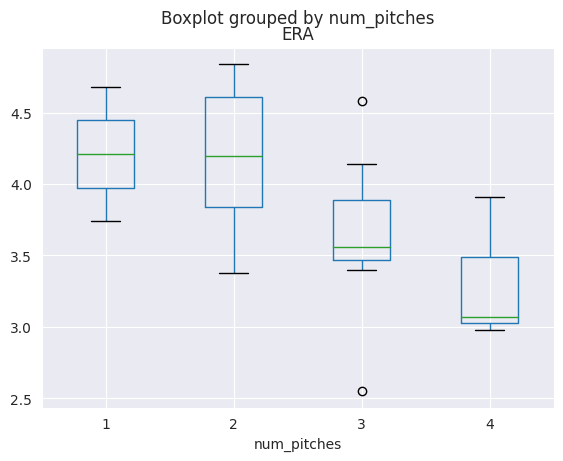

In [22]:
### 산출한 제구력에 따라 KBO에서의 ERA 확인 - 제구가 되는 구종의 개수가 많을 수록 ERA가 낮게 나옴
Elite_11_18 = Elite_11_18.reset_index()
Elite_11_18 = Elite_11_18.merge(coordEdge, on = "pitcher_name")
Elite_11_18.boxplot("ERA", "num_pitches");

In [23]:
### 선형회귀분석을 통해 검증
y = Elite_11_18.ERA.values
X = sm.add_constant(Elite_11_18.num_pitches.values)

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     5.861
Date:                Fri, 27 Oct 2023   Prob (F-statistic):             0.0277
Time:                        06:12:25   Log-Likelihood:                -14.248
No. Observations:                  18   AIC:                             32.50
Df Residuals:                      16   BIC:                             34.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7731      0.414     11.543      0.000       3.896       5.650
x1            -0.3629      0.150     -2.421      0.028      -0.681      -0.045
==============================================================================
Omnibus:                        0.141   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.346
Skew:                          -0.120   Prob(JB):                        0.841
Kurtosis:                       2.365   Cond. No.                         9.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **_아웃 확률 추정하기**

- 제구력이 동점일 경우 "아웃 확률"을 사용

- 아웃 확률은 투수가 한 이닝에 상대하는 타자의 수가 따르는 음이항 분포에서 나오는 모수,
    - 논문(1996), "Modeling Pitcher Performance and the Distribution of Runs per Inning in Major League Baseball"
    - 음이항 분포: 해당 사건이 k번 발생하기까지 시행한 횟수
    - 즉, 한 이닝에 아웃 3번을 잡을 때까지 상대한 타자의 수

    

#### **투수의 이닝별 타자 및 타석 결과**

In [24]:
### 타자의 타석 결과
(atkbo_11_18_StatCast[["batter", "events", "description"]].query("events.notnull()", engine = "python").
                                                           head(10))

,batter,events,description
0,425834.0,field_out,hit_into_play
1,150289.0,home_run,hit_into_play_score
7,430632.0,field_out,hit_into_play
10,446481.0,single,hit_into_play_no_out
12,446334.0,field_out,hit_into_play
15,116338.0,field_out,hit_into_play
19,110029.0,field_out,hit_into_play
25,435062.0,field_out,hit_into_play
29,488721.0,home_run,hit_into_play_score
31,430948.0,field_out,hit_into_play


In [25]:
### 이닝별 상대 타자 수를 산출하기 위해 해당 데이터를 순차적으로 순회하며 직접 카운팅
def recordInning(key, dic):
    if dic.get(key) == None:
        dic[key] = 1
    else:
        dic[key] += 1
    return dic

def getInningResult(data):
    batterCount = 0
    batterCountTemp = 0
    outs = ["out", "out", "out"]
    inningDict = {}

    for idx in range(len(data) - 1, -1, -1):
        batterCount += 1
        if "out" in data.events.iloc[idx]:
            outs.pop()

        # 아웃이 3번 나오면
        if len(outs) == 0:
            _key = f"I_{batterCount - batterCountTemp}"
            inningDict = recordInning(_key, inningDict)
            batterCountTemp = batterCount
            if idx != 0:
                outs = ["out", "out", "out"]

    if len(outs) != 0:
        _key = f"I_{batterCount - batterCountTemp + len(outs)}"
        inningDict = recordInning(_key, inningDict)

    return pd.DataFrame(data = dict(sorted(inningDict.items())), index = [0])


In [26]:
MLB_11_18_InningSummary = (atkbo_11_18_StatCast.query("events.notnull()", engine = "python").
                                                groupby(["pitcher_name", "game_date"]).
                                                apply(getInningResult))
MLB_11_18_InningSummary.head()

# 니퍼트는 2010.06.06 경기날 2이닝 동안 각각 6명의 타자를 상대
# 니퍼트는 2010.06.09 경기날 1이닝 동안 7명의 타자를 상대

I_6  I_7  I_4  I_5  I_8  I_3  I_12  I_10  I_9  \
pitcher_name game_date                                                     
니퍼트          2010-06-06 0  2.0  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN   
             2010-06-09 0  NaN  1.0  NaN  NaN  NaN  NaN   NaN   NaN  NaN   
             2010-06-17 0  NaN  NaN  1.0  1.0  1.0  NaN   NaN   NaN  NaN   
             2010-06-23 0  1.0  1.0  1.0  NaN  NaN  NaN   NaN   NaN  NaN   
             2010-06-30 0  1.0  NaN  1.0  NaN  NaN  1.0   NaN   NaN  NaN   

                           I_11  I_14  I_13  I_17  I_16  
pitcher_name game_date                                   
니퍼트          2010-06-06 0   NaN   NaN   NaN   NaN   NaN  
             2010-06-09 0   NaN   NaN   NaN   NaN   NaN  
             2010-06-17 0   NaN   NaN   NaN   NaN   NaN  
             2010-06-23 0   NaN   NaN   NaN   NaN   NaN  
             2010-06-30 0   NaN   NaN   NaN   NaN   NaN

In [27]:
# 위의 결과를 투수별 col을 기준으로 합을 한다면, 투수별 MLB에서의 모든 경기 기록 합산 결과를 도출
MLB_11_18_InningSummary = (MLB_11_18_InningSummary.groupby("pitcher_name").
                                                   sum()[sorted(MLB_11_18_InningSummary.columns)])
MLB_11_18_InningSummary.head()

,I_10,I_11,I_12,I_13,I_14,I_16,I_17,I_3,I_4,I_5,I_6,I_7,I_8,I_9
pitcher_name,,,,,,,,,,,,,,
니퍼트,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,14.0,2.0,6.0,3.0,1.0,0.0
다이아몬드,6.0,1.0,0.0,0.0,1.0,0.0,0.0,105.0,65.0,60.0,33.0,25.0,22.0,6.0
듀브론트,9.0,1.0,1.0,0.0,0.0,0.0,0.0,146.0,150.0,79.0,63.0,29.0,26.0,14.0
레나도,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.0,25.0,15.0,9.0,10.0,3.0,1.0
레온,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,6.0,4.0,3.0,1.0,0.0


In [28]:
# 전체 투수 중 Elite_11_18에 기록된 선수
MLB_11_18_InningSummary = MLB_11_18_InningSummary.reset_index()

Elite_11_18_InningSummary = (MLB_11_18_InningSummary.query("pitcher_name in @ Elite_11_18.pitcher_name").
                                                     reset_index(drop = True))
Elite_11_18_InningSummary

,pitcher_name,I_10,I_11,I_12,I_13,I_14,I_16,I_17,I_3,I_4,I_5,I_6,I_7,I_8,I_9
0,니퍼트,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,14.0,2.0,6.0,3.0,1.0,0.0
1,다이아몬드,6.0,1.0,0.0,0.0,1.0,0.0,0.0,105.0,65.0,60.0,33.0,25.0,22.0,6.0
2,레이예스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,43.0,24.0,17.0,10.0,9.0,5.0
3,레일리,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,12.0,6.0,6.0,1.0,3.0,2.0
4,린드블럼,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,41.0,35.0,15.0,9.0,2.0,1.0
5,보우덴,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,49.0,12.0,21.0,6.0,2.0,1.0
6,샘슨,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,21.0,13.0,20.0,8.0,5.0,2.0
7,세든,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,13.0,11.0,6.0,4.0,3.0,1.0
8,소사,1.0,1.0,0.0,0.0,0.0,0.0,0.0,17.0,5.0,11.0,11.0,2.0,2.0,0.0
9,웨버,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,4.0,2.0,2.0,0.0


#### **논문 기반 아웃 확률 계산**

In [29]:
### 위 정보를 바탕으로 투수별 아웃 확률을 산출 - 위에서 언급한 논문의 공식을 사용
def makeC1(data):
    '''
    parameters: data - InningSummary
    Returns: pd.Series - 논문에서 정의한 C1값
    '''
    return data.sum(axis = 1)


def makeC2(data):
    '''
    parameters: data - InningSummary
    Returns: pd.Series - 논문에서 정의한 C2값
    '''
    return 3* (data["I_3"] + data["I_4"])


def makeC3(data):
    '''
    parameters: data - InningSummary
    Returns: pd.Series - 논문에서 정의한 C3값
    '''
    output = 0
    for N in range(5, 18):
        try:
            output += (N - 3) * data[f"I_{N}"]
        except:
            continue

    return output

def makeDelta(data):
    '''
    parameters: data - InningSummary
    Returns: pd.Series - 논문에서 정의한 Delata 값
    '''
    Delta = ((-data["C1"] + data["C2"] + 2*data["C3"])+
             ((data["C1"] - data["C2"] - 2*data["C3"]).pow(2) +
              4*data["C3"]*(3*data["C1"] + data["C2"] + 3*data["C3"])).pow(0.5))
    Delta = Delta / (2*(3*data["C1"] + data["C2"] + 3*data["C3"]))

    return Delta



def makeOutProb(data):
    '''
    parameters: data - InningSummary
    Returns: pd.DataFrame - InningSummary with C1, C2, C3, Delta, OutProb
    '''
    data["C1"] = makeC1(data)
    data["C2"] = makeC2(data)
    data["C3"] = makeC3(data)

    data["Delta"] = makeDelta(data)
    data["outprob"] = 1 - data["Delta"]

    return data



In [30]:
Elite_11_18_InningSummary = makeOutProb(Elite_11_18_InningSummary)
Elite_11_18_InningSummary.sort_values("outprob", ascending = False)

,pitcher_name,I_10,I_11,I_12,I_13,I_14,I_16,I_17,I_3,I_4,I_5,I_6,I_7,I_8,I_9,C1,C2,C3,Delta,outprob
5,보우덴,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,49.0,12.0,21.0,6.0,2.0,1.0,128.0,258.0,127.0,0.586895,0.413105
4,린드블럼,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,41.0,35.0,15.0,9.0,2.0,1.0,157.0,285.0,167.0,0.591972,0.408028
7,세든,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,13.0,11.0,6.0,4.0,3.0,1.0,62.0,111.0,77.0,0.619771,0.380229
13,피가로,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,22.0,28.0,12.0,5.0,3.0,1.0,102.0,159.0,133.0,0.621519,0.378481
14,피어밴드,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,0.0,1.0,1.0,0.0,10.0,18.0,13.0,0.628539,0.371461
0,니퍼트,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,14.0,2.0,6.0,3.0,1.0,0.0,35.0,66.0,48.0,0.640926,0.359074
16,헥터,6.0,4.0,0.0,0.0,0.0,0.0,0.0,123.0,96.0,75.0,44.0,33.0,9.0,7.0,397.0,657.0,575.0,0.644372,0.355628
10,윌슨,0.0,0.0,1.0,0.0,0.0,0.0,0.0,42.0,38.0,24.0,22.0,9.0,6.0,4.0,146.0,240.0,213.0,0.645420,0.354580
3,레일리,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,12.0,6.0,6.0,1.0,3.0,2.0,41.0,69.0,61.0,0.650185,0.349815
2,레이예스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,43.0,24.0,17.0,10.0,9.0,5.0,142.0,231.0,214.0,0.651042,0.348958


#### **2019년 스카우트 대상 투수의 성적 확인**

In [31]:
edgePitches_19 = (atkbo_19_StatCast.query('(plate_x >= 0.8 & plate_x <= 1.2 & plate_z <= 3.7 & plate_z >= 1.3) | \
                                           (plate_x <= -0.8 & plate_x >= -1.2 & plate_z <= 3.7 & plate_z >= 1.3) | \
                                           (plate_x >= -0.8 & plate_x <= 0.8 & plate_z <= 1.7 & plate_z >= 1.3) | \
                                           (plate_x >= -0.8 & plate_x <= 0.8 & plate_z <= 3.7 & plate_z >= 3.3)').
                                    query('pitch_name.notnull()', engine = "python").
                                    query('description == "called_strike"'))

coordEdge_19 = (edgePitches_19[["pitcher_name", "pitch_name", "game_date"]].groupby(["pitcher_name", "pitch_name"]).
                                                                            count().
                                                                            groupby("pitcher_name").
                                                                            apply(lambda x: x / x.sum()).
                                                                            query("game_date >= 0.1").
                                                                            groupby("pitcher_name").
                                                                            count())

MLB_19_InningSummary = (atkbo_19_StatCast.query("events.notnull()", engine = "python").
                                          groupby(["pitcher_name", "game_date"]).
                                          apply(getInningResult))

MLB_19_InningSummary = (MLB_19_InningSummary.groupby("pitcher_name").
                                             sum()[sorted(MLB_19_InningSummary.columns)])

MLB_19_InningSummary = MLB_19_InningSummary.reset_index()

MLB_19_InningSummary = makeOutProb(MLB_19_InningSummary)
MLB_19_InningSummary.sort_values("outprob", ascending = False)

,pitcher_name,I_10,I_11,I_12,I_13,I_15,I_3,I_4,I_5,I_6,I_7,I_8,I_9,C1,C2,C3,Delta,outprob
3,서폴드,0.0,1.0,0.0,0.0,0.0,38.0,31.0,28.0,16.0,7.0,3.0,1.0,125.0,207.0,161.0,0.622278,0.377722
0,루친스키,1.0,0.0,0.0,0.0,0.0,24.0,11.0,14.0,7.0,1.0,3.0,2.0,63.0,105.0,87.0,0.635756,0.364244
5,요키시,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,3.0,0.0,0.0,1.0,15.0,21.0,23.0,0.648073,0.351927
12,헤일리,0.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0,3.0,2.0,2.0,0.0,28.0,39.0,43.0,0.648175,0.351825
6,윌랜드,1.0,0.0,0.0,0.0,0.0,20.0,11.0,6.0,7.0,5.0,3.0,1.0,54.0,93.0,81.0,0.652780,0.347220
10,터너,4.0,3.0,0.0,0.0,1.0,105.0,89.0,71.0,51.0,22.0,16.0,8.0,370.0,582.0,575.0,0.655363,0.344637
1,맥과이어,0.0,0.0,0.0,0.0,0.0,14.0,13.0,9.0,6.0,3.0,3.0,4.0,52.0,81.0,87.0,0.668831,0.331169
4,알칸타라,0.0,0.0,0.0,1.0,0.0,15.0,8.0,8.0,9.0,3.0,3.0,0.0,47.0,69.0,80.0,0.669846,0.330154
8,켈리,1.0,2.0,1.0,0.0,0.0,23.0,20.0,18.0,8.0,9.0,2.0,1.0,85.0,129.0,144.0,0.670181,0.329819
11,톰슨,0.0,0.0,1.0,0.0,0.0,31.0,29.0,15.0,13.0,12.0,7.0,5.0,113.0,180.0,191.0,0.671605,0.328395


In [32]:
### 제구력이 가장 뛰어난 선수
coordEdge_19 = coordEdge_19.reset_index().rename(columns = {"game_date" : "num_pitches"})
coordEdge_19.sort_values("num_pitches", ascending = False)

,pitcher_name,num_pitches
0,루친스키,4
7,채드벨,4
9,쿠에바스,4
1,맥과이어,3
3,서폴드,3
4,알칸타라,3
5,요키시,3
8,켈리,3
10,터너,3
11,톰슨,3


In [33]:
### 2명을 뽑기 위해 동점인 상위 3명의 아웃 확률 확인
top3_pitcher = coordEdge_19.sort_values("num_pitches", ascending = False).pitcher_name[:3]

MLB_19_InningSummary.query("pitcher_name in @ top3_pitcher")

,pitcher_name,I_10,I_11,I_12,I_13,I_15,I_3,I_4,I_5,I_6,I_7,I_8,I_9,C1,C2,C3,Delta,outprob
0,루친스키,1.0,0.0,0.0,0.0,0.0,24.0,11.0,14.0,7.0,1.0,3.0,2.0,63.0,105.0,87.0,0.635756,0.364244
7,채드벨,1.0,0.0,0.0,0.0,0.0,16.0,17.0,15.0,9.0,10.0,4.0,1.0,73.0,99.0,130.0,0.675697,0.324303
9,쿠에바스,1.0,0.0,0.0,0.0,0.0,2.0,6.0,8.0,4.0,2.0,1.0,0.0,24.0,24.0,48.0,0.689898,0.310102


## **성능 향상을 위한 방법**

- 투수 평가 시 사용할 수 있는 추가 지표를 탐색

### **_볼 배합 지표**

- 좋은 볼 배합에 대한 정의가 필요

- 여기서는 단순히 순차적으로 던진 투구 간의 거리가 멀수록 좋은 볼 조합이라고 정의

In [34]:
def Compute_Distance(x1, y1, x2, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def Mean_Distance_Per_Batter(data):
    if data.shape[0] == 1:
        return np.nan

    distances = []
    for i in range(data.shape[0]-1, 0, -1):
        distance = Compute_Distance(data["plate_x"].iloc[i], data["plate_z"].iloc[i],
                                    data["plate_x"].iloc[i-1], data["plate_z"].iloc[i-1])
        distances.append(distance)

    return np.mean(distances)

In [35]:
MDPB = atkbo_11_18_StatCast.groupby(["pitcher_name", "batter"]).apply(Mean_Distance_Per_Batter)
MDPB

pitcher_name  batter  
니퍼트           110029.0    1.418679
              113028.0    1.262822
              116338.0    1.475932
              121347.0    1.922868
              123173.0    1.306911
                            ...   
휠러            543807.0    1.312943
              545350.0    3.023675
              594828.0         NaN
              608324.0    1.542978
              621043.0         NaN
Length: 11263, dtype: float64

In [36]:
pitch_mix = MDPB.dropna().groupby("pitcher_name").mean()
pitch_mix.head()

pitcher_name
니퍼트      1.431813
다이아몬드    1.408325
듀브론트     1.469793
레나도      1.501783
레온       1.529366
dtype: float64

 #### **정의한 두 지표로 다중선형회귀 분석**

 - 정의한 제구력 지표와 볼 배합 지표를 변수로 "다중선형회귀"를 적용시켜 스카우트

In [37]:
# Elite_11_18 데이터에 볼 배합 지표 추가
Elite_11_18["PMI"] = pitch_mix[Elite_11_18.pitcher_name].values
display(Elite_11_18.head())


# 다중선형회귀 분석
y = Elite_11_18.ERA.values
X = sm.add_constant(Elite_11_18[["num_pitches", "PMI"]].values)

model = sm.OLS(y, X)
result = model.fit()
result.summary()

,index,pitcher_name,year,team,ERA,TBF,H,HR,BB,HBP,SO,year_born,num_pitches,PMI
0,0,니퍼트,2011,두산,2.55,763,150,8,64,10,150,NaN,3,1.431813
1,8,다이아몬드,2017,SK,4.42,581,163,11,35,9,59,NaN,2,1.408325
2,12,레이예스,2013,SK,4.84,751,157,15,91,7,135,NaN,2,1.449854
3,14,레일리,2015,롯데,3.91,768,182,20,57,15,134,1988년 06월 29일,4,1.505396
4,25,린드블럼,2015,롯데,3.56,861,196,28,52,12,180,1987년 06월 15일,3,1.506041


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     5.365
Date:                Fri, 27 Oct 2023   Prob (F-statistic):             0.0175
Time:                        06:12:33   Log-Likelihood:                -12.201
No. Observations:                  18   AIC:                             30.40
Df Residuals:                      15   BIC:                             33.07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0464      2.216      4.082      0.001       4.322      13.770
x1            -0.4438      0.144     -3.077      0.008      -0.751      -0.136
x2            -2.7600      1.410     -1.957      0.069      -5.766       0.246
==============================================================================
Omnibus:                        2.157   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                0.664
Skew:                          -0.351   Prob(JB):                        0.717
Kurtosis:                       3.627   Cond. No.                         69.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### **2019년 KBO 첫 시즌 ERA 예측**

In [38]:
MDPB_19 = atkbo_19_StatCast.groupby(["pitcher_name", "batter"]).apply(Mean_Distance_Per_Batter)
pitch_mix_19 = MDPB_19.dropna().groupby("pitcher_name").mean()
pitch_mix_19.head()

pitcher_name
루친스키    1.508374
맥과이어    1.412896
버틀러     1.469185
서폴드     1.510175
알칸타라    1.382733
dtype: float64

In [39]:
coordEdge_19["PMI"] = pitch_mix_19[coordEdge_19.pitcher_name].values
coordEdge_19

,pitcher_name,num_pitches,PMI
0,루친스키,4,1.508374
1,맥과이어,3,1.412896
2,버틀러,2,1.469185
3,서폴드,3,1.510175
4,알칸타라,3,1.382733
5,요키시,3,1.476024
6,윌랜드,2,1.497783
7,채드벨,4,1.446687
8,켈리,3,1.483089
9,쿠에바스,4,1.503062


In [40]:
test_X = sm.add_constant(coordEdge_19[["num_pitches", "PMI"]].values)
coordEdge_19["pred"] = result.predict(test_X)
coordEdge_19.sort_values("pred")

,pitcher_name,num_pitches,PMI,pred
0,루친스키,4,1.508374,3.108067
9,쿠에바스,4,1.503062,3.122727
11,톰슨,3,1.609576,3.272562
7,채드벨,4,1.446687,3.278323
12,헤일리,3,1.576976,3.362537
3,서폴드,3,1.510175,3.546906
8,켈리,3,1.483089,3.621663
5,요키시,3,1.476024,3.641163
10,터너,3,1.443403,3.731196
1,맥과이어,3,1.412896,3.815397


### **_배럴 타구 허용 비율**

- 배럴 타구: 타구 속도와 발사각도의 조합상 평균적으로 타율 .500, 장타율 1.500이상을 생산하는 타구
    - 해당 타구는 타자 입장에서 좋은 성적이 나오므로 타자들이 목표로 하는 타구
    - 투수 입장에서는 최소화를 해야하는 타구

- 배털 타구 허용 비율 = 투수의 배럴 타구 허용 개수/전체 투구 개수

- MLB 공식 홈페이지에 게시된 배럴 타구의 정의
    - 타구 속도가 최소 98mph, 발사 각도는 26~30도
    - 1mph 증가 시 허용되는 발사각도의 범위 증가
    - 116mph 이상부터는 발사각도가 8~50도 사이

#### **배럴 타구 허용 비율 산출 함수**

In [44]:
### 투수별 배럴 타구 개수 계산
def countBarrelPitches(data):
    lower = 26
    upper = 30

    QL = []

    for mph in range(98, int(data.launch_speed.max()) + 1):
        if mph <= 115:
            QL.append(data.query(f"(launch_speed >= {mph} & launch_speed < {mph+1}) & \
                                   (launch_angle >= {lower} & launch_angle <= {upper})"))
            lower -= 1
            upper += 20/18

        else:
            QL.append(data.query(f"(launch_speed >= {mph} & launch_speed < {mph+1}) & \
                                   (launch_angle >= {lower} & launch_angle <= {upper})"))

    BarrelPitches = (pd.concat(QL, axis = 0).groupby("pitcher_name")["game_date"].
                                             count().
                                             reset_index())
    BarrelPitches = BarrelPitches.rename({"game_date" : "barrel_pitches"}, axis = 1)

    return BarrelPitches

countBarrelPitches(atkbo_19_StatCast).head()

,pitcher_name,barrel_pitches
0,루친스키,9
1,맥과이어,16
2,버틀러,57
3,서폴드,26
4,알칸타라,18


In [43]:
### 투수별 총 투구 수 계산
def countTotalPitches(data):
    TotalPitches = data.groupby("pitcher_name")["game_date"].count().reset_index()
    TotalPitches = TotalPitches.rename({"game_date" : "total_pitches"}, axis = 1)

    return TotalPitches

countTotalPitches(atkbo_19_StatCast).head()

,pitcher_name,total_pitches
0,루친스키,930
1,맥과이어,925
2,버틀러,4454
3,서폴드,1860
4,알칸타라,824


In [45]:
### 투수 당 배럴 타구 비율 계산
def getBarrelRatio(data):
    BarrelPitches_result = countBarrelPitches(data)
    TotalPitches_result = countTotalPitches(data)

    pitches = pd.merge(BarrelPitches_result, TotalPitches_result, on = "pitcher_name", how = "right")
    pitches = pitches.fillna(0)
    pitches["barrel_ratio"] = pitches["barrel_pitches"] / pitches["total_pitches"]

    return pitches.sort_values("barrel_ratio")

In [46]:
### launch_speed와 launch_angle이 결측값인 투구는 제거 후 적용
Stat19notnull = atkbo_19_StatCast[atkbo_19_StatCast.launch_speed.notnull() &
                                  atkbo_19_StatCast.launch_angle.notnull()]
getBarrelRatio(Stat19notnull)

,pitcher_name,barrel_pitches,total_pitches,barrel_ratio
11,헤일리,6,154,0.038961
0,루친스키,9,226,0.039823
2,버틀러,57,1215,0.046914
3,서폴드,26,554,0.046931
10,톰슨,28,561,0.049911
7,켈리,14,280,0.050000
1,맥과이어,16,263,0.060837
6,채드벨,24,377,0.063660
8,쿠에바스,8,120,0.066667
9,터너,26,372,0.069892
